# **Food Delivery Time Prediction**
**Introduction**

In this project, I developed a machine learning model to predict delivery times based on critical factors such as weather, traffic, type of vehicle, distance, the delivery driver's experience and other variables. This is a supervised regression problem, where the target variable represents the total delivery time in minutes. The aim is to identify patterns that influence delivery efficiency and provide practical insights for optimizing logistics operations, especially in scenarios of high demand or adverse conditions.

**dataset url:** https://www.kaggle.com/datasets/denkuznetz/food-delivery-time-prediction

### **Definig the Business Problem**

**1.1 Context** <br>
This dataset is designed for predicting food delivery times based on various influencing factors such as distance, weather, traffic conditions, and time of day. Key features include:

- **Environmental metrics:** Weather conditions and traffic levels.
- **Operational metrics:** Type of vehicle, preparation time, delivery distance and whether it is an express or long-distance delivery.
- **Courier profile:** Years of experience.

The project aims to predict the total delivery time based on these factors

**Project Objectives**

- Identify the main factors that impact delivery time.
- Develop a machine learning model to accurately predict delivery time.

**Expected Benefits**

- **Improved Decision Making:** Data-based insights for logistics managers and delivery operators.
- **Resource Optimization:** More precise route planning, allocation of delivery personnel and definition of deadlines.
- **Customer Experience:** Reduced delays and more predictable deliveries, especially in critical scenarios (adverse weather, long distances, peak times).



In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import PCA
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


In [8]:
df = pd.read_csv("data/food-delivery-time.csv")
df.head(5)

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


### **Explore the Dataset**
**Columns**

**1. Order_ID:** Unique identifier for each order.<br>
**2. 
Distance_k**m: The delivery distance in kilometer<br>
**3. Weather:** Weather conditions during the delivery, including Clear, Rainy, Snowy, Foggy, and Windy.<br>
**4. Traffic_Level:** Traffic conditions categorized as Low, Medium, or High.<br>
**5. Time_of_Day:** The time when the delivery took place, categorized as Morning, Afternoon, Evening, or Night.<br>
**6. Vehicle_Type:** Type of vehicle used for delivery, including Bike, Scooter, and Car.<br>
**7. Preparation_Time_min:** The time required to prepare the order, measured in minutes.<br>
**8. Courier_Experience_yrs:** Experience of the courier in years.<br>
**9. Delivery_Time_min:** The total delivery time in minutes (target variable).




In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


In [11]:
df.describe()

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,1000.000000,970.000000,1000.000000
mean,500.500000,10.059970,16.982000,4.579381,56.732000
std,288.819436,5.696656,7.204553,2.914394,22.070915
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,250.750000,5.105000,11.000000,2.000000,41.000000
50%,500.500000,10.190000,17.000000,5.000000,55.500000
75%,750.250000,15.017500,23.000000,7.000000,71.000000
max,1000.000000,19.990000,29.000000,9.000000,153.000000


In [12]:
df.shape

(1000, 9)

In [13]:
# i will take care of it in the pipeline
df.isna().sum()

Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

# **Exploratory Data Analysis**

In [15]:
# Numerical Features
numerical_features = ["Delivery_Time_min", "Distance_km", "Preparation_Time_min", "Courier_Experience_yrs"]

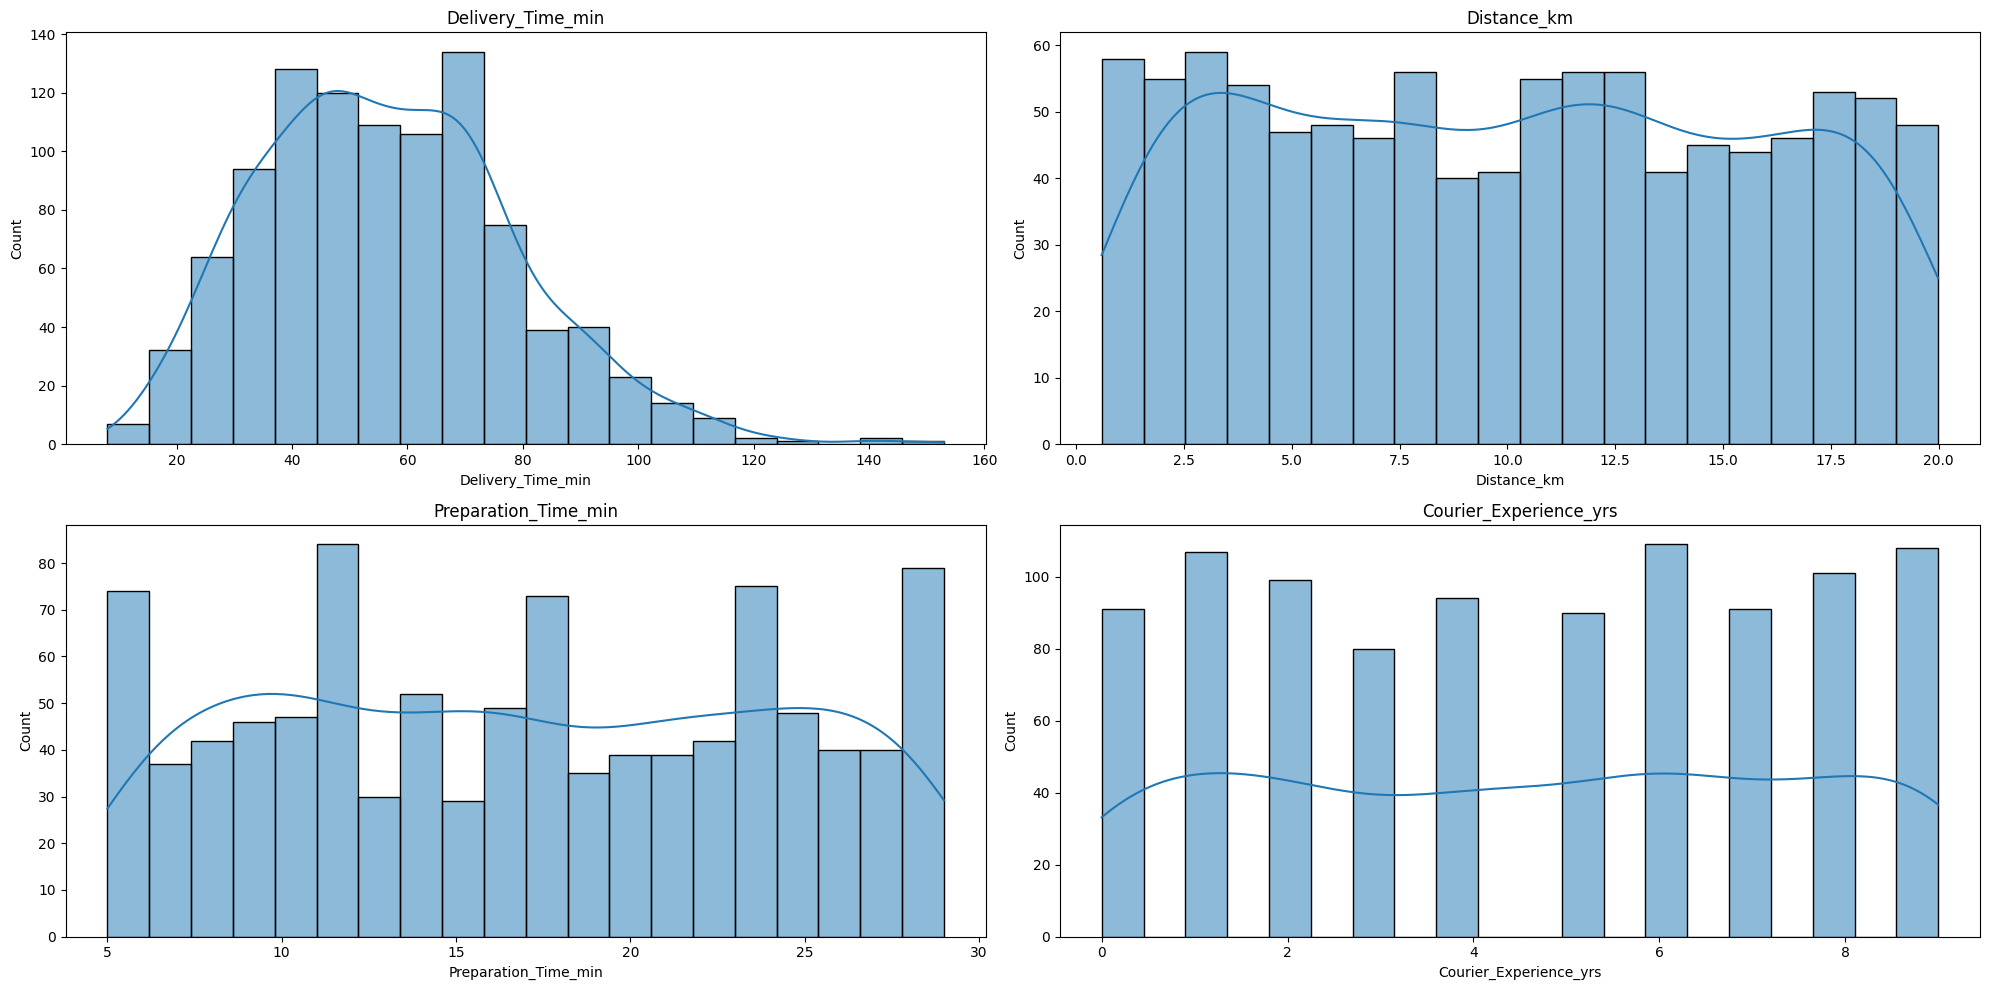

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
axes = axes.flatten()  # transform in list to facility access

for i, feature in enumerate(numerical_features):
    sns.histplot(x=df[feature], kde=True, bins=20, ax=axes[i], palette="Blues")
    axes[i].set_title(feature)

# Delete missing graph
#if len(numerical_features) < len(axes):
#    for j in range(len(numerical_features), len(axes)):
#        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

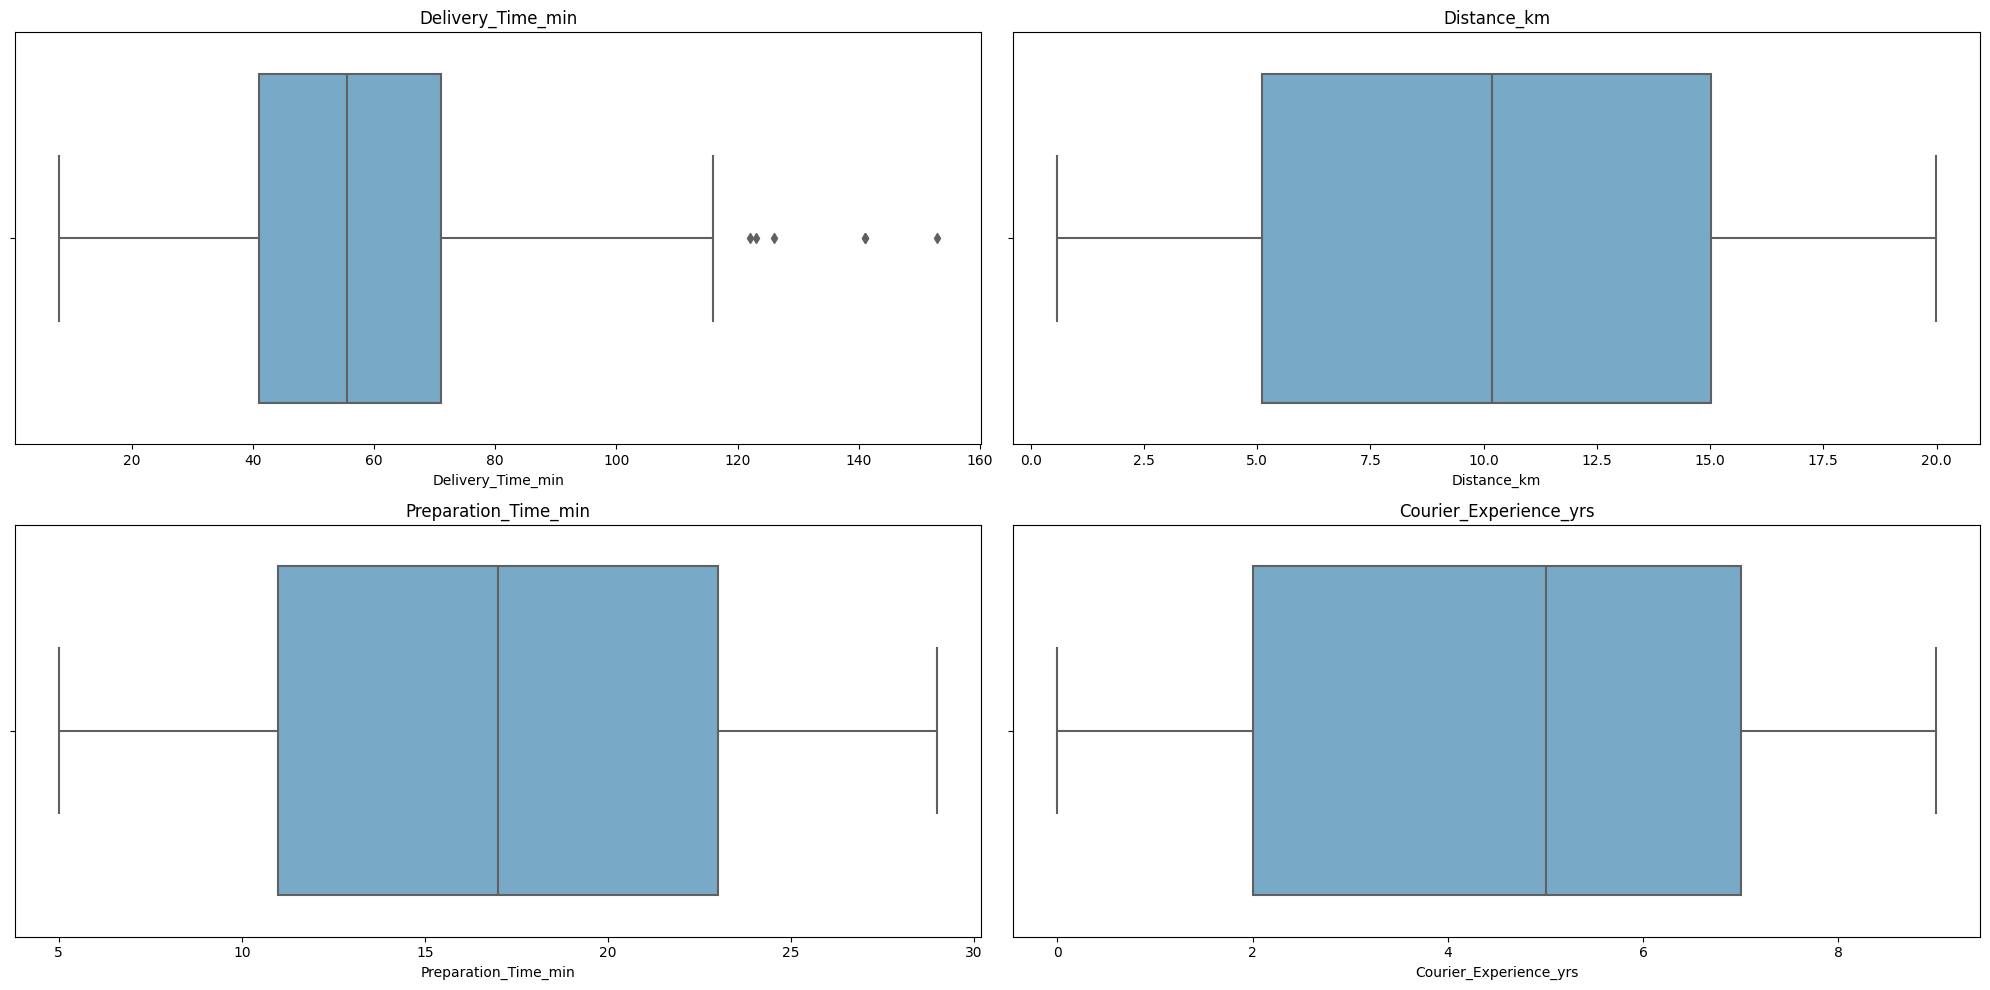

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
axes = axes.flatten()  # transform in list to facility access

for i, feature in enumerate(numerical_features):
    sns.boxplot(x=df[feature], ax=axes[i], palette='Blues')
    axes[i].set_title(feature)

# Delete missing graph
#if len(numerical_features) < len(axes):
#    for j in range(len(numerical_features), len(axes)):
#        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Main Insights**

- Most deliveries take place between 30 and 80 minutes
- There are no extreme peaks or concentrations that indicate a fixed distance pattern. This may suggest that the service operates in a geographically wide and diverse area.
- It may indicate different types of establishments with different preparation time patterns (e.g. fast-food vs. gourmet restaurants).

In [19]:
df['Delivery_Time_min'].describe()

count    1000.000000
mean       56.732000
std        22.070915
min         8.000000
25%        41.000000
50%        55.500000
75%        71.000000
max       153.000000
Name: Delivery_Time_min, dtype: float64

In [20]:
categorical_features = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']

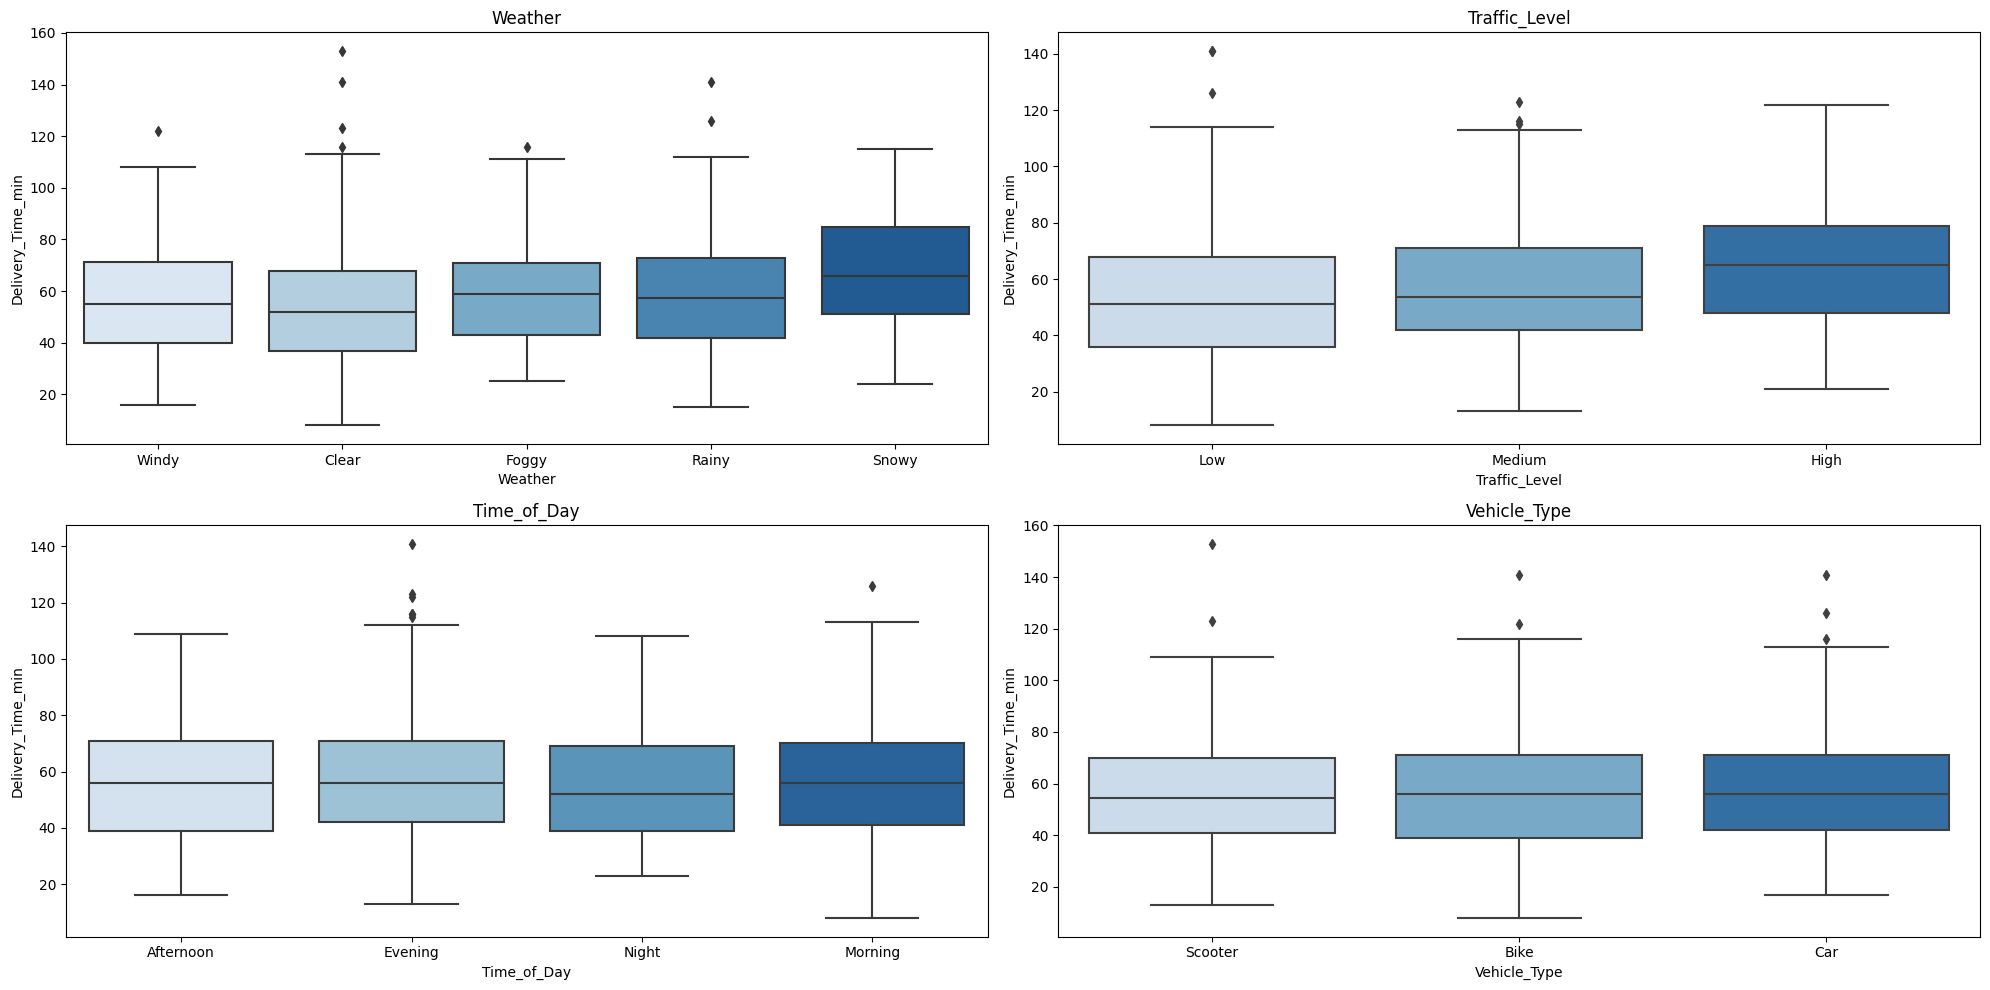

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
axes = axes.flatten()  # transform in list to facility access

for i, feature in enumerate(categorical_features):
    sns.boxplot(x=df[feature], y=df['Delivery_Time_min'], ax=axes[i], palette='Blues')
    axes[i].set_title(feature)

# Delete missing graph
#if len(numerical_features) < len(axes):
#    for j in range(len(numerical_features), len(axes)):
#        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

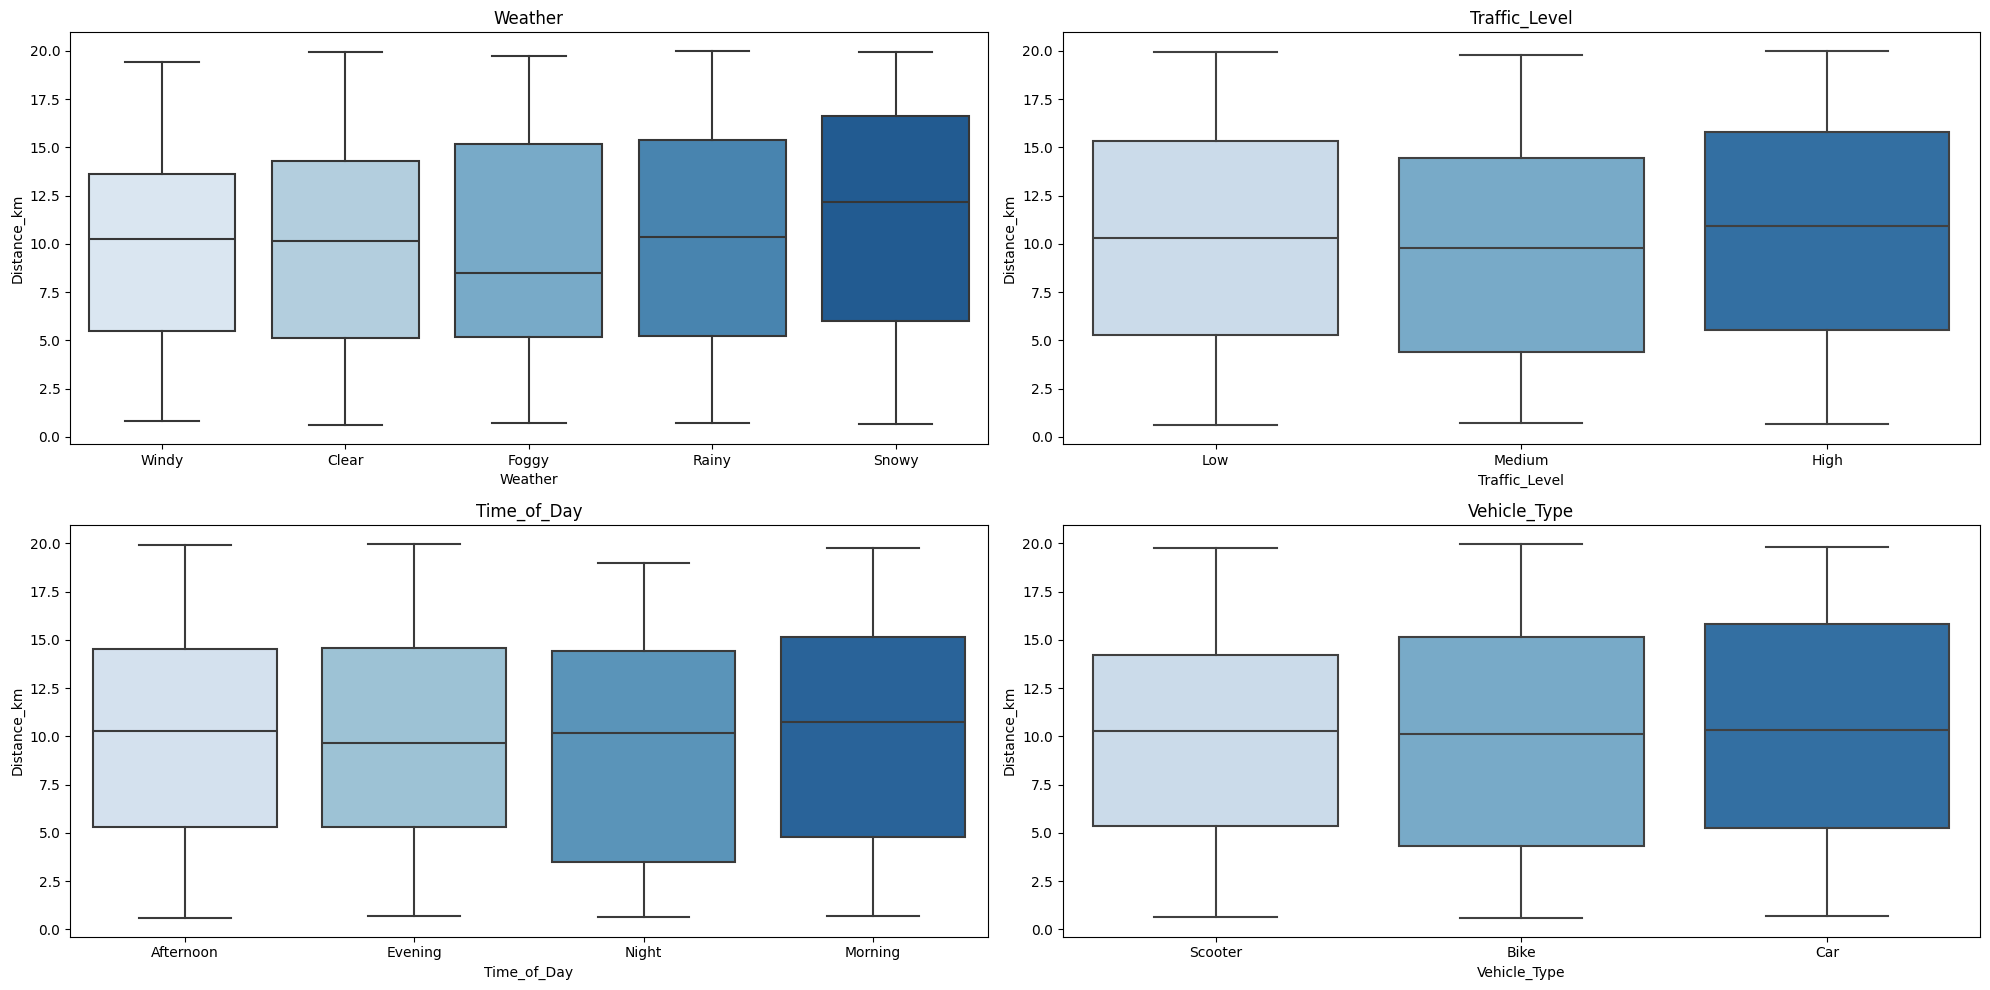

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
axes = axes.flatten()  # transform in list to facility access

for i, feature in enumerate(categorical_features):
    sns.boxplot(x=df[feature], y=df['Distance_km'], ax=axes[i], palette='Blues')
    axes[i].set_title(feature)

# Delete missing graph
#if len(numerical_features) < len(axes):
#    for j in range(len(numerical_features), len(axes)):
#        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<Axes: xlabel='Weather', ylabel='count'>

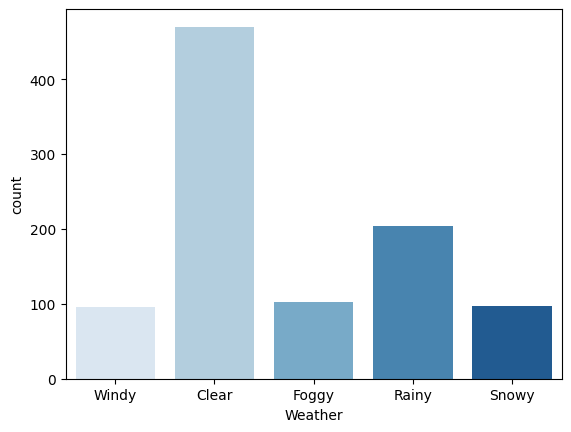

In [23]:
sns.countplot(x=df['Weather'], palette='Blues')

**Main Insights**

- **Snowy** tends to increase delivery time. The median is higher and the dispersion is greater.
- **Clear** and **Windy** seem to have lower median delivery times.
- The higher the traffic, the longer the delivery time.
- Subtle differences, but **Morning** seems to have the longest median delivery time.
- **Scooters** seem to perform slightly better, perhaps because they can avoid traffic more easily.



**Creating new features**

In [26]:
df['Distance_km'].describe()

count    1000.000000
mean       10.059970
std         5.696656
min         0.590000
25%         5.105000
50%        10.190000
75%        15.017500
max        19.990000
Name: Distance_km, dtype: float64

In [27]:
# Creating Distance_km_fx on df
df['Distance_km_fx'] = pd.cut(df['Distance_km'], bins=[0, 5.1050, 10.1900, 15.0175, np.inf],
                              labels=['near', 'ok', 'far', 'very far'])

In [28]:
df['Delivery_Time_min'].quantile([0.25, 0.5, 0.75])

0.25    41.0
0.50    55.5
0.75    71.0
Name: Delivery_Time_min, dtype: float64

In [29]:
# Creating Delivery_Time_min_fx on df
df['Delivery_Time_min_fx'] = pd.cut(df['Delivery_Time_min'], bins=[0, 41, 55.5, 71, np.inf],
                              labels=['fast', 'ok', 'low', 'very low'])

In [30]:
# It reflects that a distance of 5 km in high traffic is "worth more" than 5 km in low traffic.
traffic_map = {'Low': 1, 'Medium': 1.5, 'High': 2}
df['Traffic_Factor'] = df['Traffic_Level'].map(traffic_map)
df['Effective_Distance'] = df['Distance_km'] * df['Traffic_Factor']

In [31]:
# Creating a feature to try improve de model
df['Is_Bad_Weather'] = df['Weather'].isin(['Rainy', 'Snowy', 'Foggy']).astype(int)

In [32]:
# Calculate Median
median_distance = df['Distance_km'].median()
# Create a boolean feature
df['Is_Long_Distance'] = (df['Distance_km'] > median_distance).astype(int)


**Correlations**

In [34]:
correlacoes = df[['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs', 'Delivery_Time_min']].corr()
correlacoes

,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
Distance_km,1.000000,-0.009037,-0.007842,0.780998
Preparation_Time_min,-0.009037,1.000000,-0.030830,0.307350
Courier_Experience_yrs,-0.007842,-0.030830,1.000000,-0.090433
Delivery_Time_min,0.780998,0.307350,-0.090433,1.000000


In [35]:
ctab = pd.crosstab([df['Traffic_Level']],
                   df['Delivery_Time_min_fx'])
ctab = ctab.div(ctab.sum(axis=1), axis=0) * 100
ctab = ctab.applymap(lambda x: f'{x:.1f}%')
ctab

Delivery_Time_min_fx,fast,ok,low,very low
Traffic_Level,,,,
High,16.8%,19.3%,28.9%,35.0%
Low,32.9%,22.5%,27.4%,17.2%
Medium,24.9%,27.7%,23.8%,23.6%


In [36]:
ctab = pd.crosstab([df['Time_of_Day']],
                   df['Delivery_Time_min_fx'])
ctab = ctab.div(ctab.sum(axis=1), axis=0) * 100
ctab = ctab.applymap(lambda x: f'{x:.1f}%')
ctab

Delivery_Time_min_fx,fast,ok,low,very low
Time_of_Day,,,,
Afternoon,28.2%,21.1%,26.8%,23.9%
Evening,23.9%,25.9%,25.9%,24.2%
Morning,26.0%,23.7%,28.9%,21.4%
Night,30.6%,25.9%,22.4%,21.2%


In [37]:
ctab = pd.crosstab([df['Weather']],
                   df['Delivery_Time_min_fx'])
ctab = ctab.div(ctab.sum(axis=1), axis=0) * 100
ctab = ctab.applymap(lambda x: f'{x:.1f}%')
ctab

Delivery_Time_min_fx,fast,ok,low,very low
Weather,,,,
Clear,30.6%,25.5%,24.9%,18.9%
Foggy,22.3%,19.4%,34.0%,24.3%
Rainy,23.0%,24.5%,25.5%,27.0%
Snowy,12.4%,19.6%,30.9%,37.1%
Windy,27.1%,24.0%,24.0%,25.0%


In [38]:
ctab = pd.crosstab([df['Vehicle_Type']],
                   df['Delivery_Time_min_fx'])
ctab = ctab.div(ctab.sum(axis=1), axis=0) * 100
ctab = ctab.applymap(lambda x: f'{x:.1f}%')
ctab

Delivery_Time_min_fx,fast,ok,low,very low
Vehicle_Type,,,,
Bike,27.0%,22.3%,26.2%,24.5%
Car,23.6%,25.1%,27.2%,24.1%
Scooter,26.5%,25.5%,26.5%,21.5%


In [39]:
ctab = pd.crosstab([df['Vehicle_Type'], df['Time_of_Day']],
                   df['Delivery_Time_min_fx'])
ctab = ctab.div(ctab.sum(axis=1), axis=0) * 100
ctab = ctab.applymap(lambda x: f'{x:.1f}%')
ctab

Delivery_Time_min_fx       fast     ok    low very low
Vehicle_Type Time_of_Day                              
Bike         Afternoon    31.4%  17.1%  26.4%    25.0%
             Evening      22.7%  24.7%  27.3%    25.3%
             Morning      25.0%  22.9%  30.7%    21.4%
             Night        31.5%  27.8%  18.5%    22.2%
Car          Afternoon    22.6%  20.8%  30.2%    26.4%
             Evening      22.0%  28.0%  30.0%    20.0%
             Morning      24.3%  29.7%  21.6%    24.3%
             Night        38.5%  15.4%  23.1%    23.1%
Scooter      Afternoon    26.4%  27.5%  25.3%    20.9%
             Evening      26.9%  26.9%  21.5%    24.7%
             Morning      28.7%  20.2%  31.9%    19.1%
             Night        22.2%  27.8%  33.3%    16.7%

In [40]:
ctab = pd.crosstab([df['Traffic_Level'], df['Time_of_Day']],
                   df['Delivery_Time_min_fx'])
ctab = ctab.div(ctab.sum(axis=1), axis=0) * 100
ctab = ctab.applymap(lambda x: f'{x:.1f}%')
ctab

Delivery_Time_min_fx        fast     ok    low very low
Traffic_Level Time_of_Day                              
High          Afternoon    17.2%  15.5%  31.0%    36.2%
              Evening      16.4%  25.5%  21.8%    36.4%
              Morning      16.1%  17.7%  37.1%    29.0%
              Night        22.2%  22.2%  16.7%    38.9%
Low           Afternoon    33.6%  26.1%  26.9%    13.4%
              Evening      29.4%  23.9%  26.6%    20.2%
              Morning      36.6%  17.0%  30.4%    16.1%
              Night        29.6%  25.9%  29.6%    14.8%
Medium        Afternoon    28.9%  19.6%  21.6%    29.9%
              Evening      23.3%  28.3%  27.5%    20.8%
              Morning      22.0%  31.5%  22.8%    23.6%
              Night        32.4%  29.7%  21.6%    16.2%

# **Modelling**

#### **Xgboost Regressor**

In [43]:
df.columns

Index(['Order_ID', 'Distance_km', 'Weather', 'Traffic_Level', 'Time_of_Day',
       'Vehicle_Type', 'Preparation_Time_min', 'Courier_Experience_yrs',
       'Delivery_Time_min', 'Distance_km_fx', 'Delivery_Time_min_fx',
       'Traffic_Factor', 'Effective_Distance', 'Is_Bad_Weather',
       'Is_Long_Distance'],
      dtype='object')

In [44]:
df.drop(['Order_ID', 'Is_Long_Distance', 'Is_Bad_Weather',
       'Traffic_Factor'], axis=1, inplace=True)

In [45]:
df.isna().sum()

Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
Distance_km_fx             0
Delivery_Time_min_fx       0
Effective_Distance        30
dtype: int64

In [46]:
X, y = df.drop('Delivery_Time_min', axis=1), df['Delivery_Time_min']

In [47]:
X.columns

Index(['Distance_km', 'Weather', 'Traffic_Level', 'Time_of_Day',
       'Vehicle_Type', 'Preparation_Time_min', 'Courier_Experience_yrs',
       'Distance_km_fx', 'Delivery_Time_min_fx', 'Effective_Distance'],
      dtype='object')

In [48]:
X

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Distance_km_fx,Delivery_Time_min_fx,Effective_Distance
0,7.93,Windy,Low,Afternoon,Scooter,12,1.0,ok,ok,7.93
1,16.42,Clear,Medium,Evening,Bike,20,2.0,very far,very low,24.63
2,9.52,Foggy,Low,Night,Scooter,28,1.0,ok,low,9.52
3,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,ok,fast,11.16
4,19.03,Clear,Low,Morning,Bike,16,5.0,very far,low,19.03
...,...,...,...,...,...,...,...,...,...,...
995,8.50,Clear,High,Evening,Car,13,3.0,ok,ok,17.00
996,16.28,Rainy,Low,Morning,Scooter,8,9.0,very far,low,16.28
997,15.62,Snowy,High,Evening,Scooter,26,2.0,very far,very low,31.24
998,14.17,Clear,Low,Afternoon,Bike,8,0.0,far,ok,14.17


In [49]:
imp_avg = ['Courier_Experience_yrs']
imp_cat = ['Weather', 'Traffic_Level', 'Time_of_Day']
cols_onehot = ['imp_cat__Weather', 'imp_cat__Traffic_Level', 'imp_cat__Time_of_Day', 'remainder__Vehicle_Type', 'remainder__Delivery_Time_min_fx',
              'remainder__Distance_km_fx']


In [50]:
pipeline = Pipeline(
    steps=[
        # Imputing missing values
        ('imp', ColumnTransformer(
            transformers = [
                # name, imputation strategy and columns
                # set_output to transform on a table again after .fit_transform
                ('imp_num', SimpleImputer(strategy='mean').set_output(transform='pandas'), imp_avg),
                ('imp_cat', SimpleImputer(strategy='most_frequent').set_output(transform='pandas'), imp_cat)
            ]
        , remainder = 'passthrough').set_output(transform='pandas')),
        # OneHotEncoding to categorical features
        ('cat', ColumnTransformer(
            transformers=[
                ('ohe', OneHotEncoder(drop='first', sparse_output=False).set_output(transform='pandas'), cols_onehot)
            ]
        , remainder='passthrough').set_output(transform='pandas')),
        ('norm', PowerTransformer(method='yeo-johnson').set_output(transform='pandas')),
        ('scale', StandardScaler().set_output(transform='pandas'))
    ])

In [51]:
pipeline

Pipeline(steps=[('imp',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imp_num', SimpleImputer(),
                                                  ['Courier_Experience_yrs']),
                                                 ('imp_cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Weather', 'Traffic_Level',
                                                   'Time_of_Day'])])),
                ('cat',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['imp_cat__Weather',
                                                   'imp_cat__Traffic_Level',
                                                   'imp_cat__Time_of_Day',
                                                   'remainder__Vehicle_Type',
                                                   'remainder__Delivery_Time_min_fx',
                                                   'remainder__Distance_km_fx'])])),
                ('norm', PowerTransformer()), ('scale', StandardScaler())])

In [52]:
X = pipeline.fit_transform(X)

In [53]:
X

,ohe__imp_cat__Weather_Foggy,ohe__imp_cat__Weather_Rainy,ohe__imp_cat__Weather_Snowy,ohe__imp_cat__Weather_Windy,ohe__imp_cat__Traffic_Level_Low,ohe__imp_cat__Traffic_Level_Medium,ohe__imp_cat__Time_of_Day_Evening,ohe__imp_cat__Time_of_Day_Morning,ohe__imp_cat__Time_of_Day_Night,ohe__remainder__Vehicle_Type_Car,...,ohe__remainder__Delivery_Time_min_fx_low,ohe__remainder__Delivery_Time_min_fx_ok,ohe__remainder__Delivery_Time_min_fx_very low,ohe__remainder__Distance_km_fx_near,ohe__remainder__Distance_km_fx_ok,ohe__remainder__Distance_km_fx_very far,remainder__imp_num__Courier_Experience_yrs,remainder__remainder__Distance_km,remainder__remainder__Preparation_Time_min,remainder__remainder__Effective_Distance
0,-0.338862,-0.506242,-0.327749,3.068659,1.269238,-0.850963,-0.643760,-0.714545,-0.304789,-0.492175,...,-0.600453,1.789324,-0.554247,-0.57735,1.732051,-0.577350,-1.269123,-0.281086,-0.644896,-0.551298
1,-0.338862,-0.506242,-0.327749,-0.325875,-0.787874,1.175139,1.553374,-0.714545,-0.304789,-0.492175,...,-0.600453,-0.558870,1.804250,-0.57735,-0.577350,1.732051,-0.857608,1.083056,0.465597,1.113865
2,2.951057,-0.506242,-0.327749,-0.325875,1.269238,-0.850963,-0.643760,-0.714545,3.280961,-0.492175,...,1.665408,-0.558870,-0.554247,-0.57735,1.732051,-0.577350,-1.269123,-0.001928,1.449266,-0.337095
3,-0.338862,1.975338,-0.327749,-0.325875,-0.787874,1.175139,-0.643760,-0.714545,-0.304789,-0.492175,...,-0.600453,-0.558870,-0.554247,-0.57735,1.732051,-0.577350,-1.269123,-0.370199,-1.814835,-0.135415
4,-0.338862,-0.506242,-0.327749,-0.325875,1.269238,-0.850963,-0.643760,1.399493,-0.304789,-0.492175,...,1.665408,-0.558870,-0.554247,-0.57735,-0.577350,1.732051,0.212352,1.455809,-0.069247,0.658109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.338862,-0.506242,-0.327749,-0.325875,-0.787874,-0.850963,1.553374,-0.714545,-0.304789,2.031798,...,-0.600453,1.789324,-0.554247,-0.57735,1.732051,-0.577350,-0.479696,-0.179338,-0.496385,0.474360
996,-0.338862,1.975338,-0.327749,-0.325875,1.269238,-0.850963,-0.643760,1.399493,-0.304789,-0.492175,...,1.665408,-0.558870,-0.554247,-0.57735,-0.577350,1.732051,1.444459,1.062582,-1.279126,0.406252
997,-0.338862,-0.506242,3.051111,-0.325875,-0.787874,-0.850963,1.553374,-0.714545,-0.304789,-0.492175,...,-0.600453,-0.558870,1.804250,-0.57735,-0.577350,1.732051,-0.857608,0.965349,1.212207,1.581240
998,-0.338862,-0.506242,-0.327749,-0.325875,1.269238,-0.850963,-0.643760,-0.714545,-0.304789,-0.492175,...,-0.600453,1.789324,-0.554247,-0.57735,-0.577350,-0.577350,-1.738544,0.747339,-1.279126,0.196401


In [54]:
# Split data on train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [55]:
model = xgb.XGBRegressor(random_state=42)

In [56]:
model = TransformedTargetRegressor(
    regressor=model,
    transformer=StandardScaler()
)

In [57]:
# Search best params
param_grid = {
    'regressor__n_estimators': [100, 300, 500],
    'regressor__max_depth': [3, 5, 7, 10],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.3],
    'regressor__subsample': [0.6, 0.8, 1],
    'regressor__colsample_bytree': [0.6, 0.8, 1],
    'regressor__gamma': [0, 0.1, 0.2]
}


search = RandomizedSearchCV(model, param_grid, n_iter=30, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
search.fit(X_train, y_train)
best_model = search.best_estimator_
best_model

TransformedTargetRegressor(regressor=XGBRegressor(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=0.8,
                                                  device=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  feature_weights=None, gamma=0,
                                                  grow_policy=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                                  learning_rate=0.01,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=5, max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  multi_strategy=None,
                                                  n_estimators=500, n_jobs=None,
                                                  num_parallel_tree=None, ...),
                           transformer=StandardScaler())

In [58]:
best_model.fit(X_train, y_train)

TransformedTargetRegressor(regressor=XGBRegressor(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=0.8,
                                                  device=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  feature_weights=None, gamma=0,
                                                  grow_policy=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                                  learning_rate=0.01,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=5, max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  multi_strategy=None,
                                                  n_estimators=500, n_jobs=None,
                                                  num_parallel_tree=None, ...),
                           transformer=StandardScaler())

In [59]:
y_pred = best_model.predict(X_test)

In [60]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = mse ** 0.5

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R2: {r2:.2f}')
print(f'Raiz Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 4.71
Mean Squared Error: 47.36
R2: 0.90
Raiz Mean Squared Error: 6.88


In [61]:
predictions = best_model.predict(X_test)
predictions

array([ 34.947037,  60.74618 ,  35.98986 ,  46.056313,  88.71942 ,
        30.909548,  80.53458 ,  32.03627 ,  83.10036 ,  86.897995,
        65.66592 ,  63.61045 ,  34.923332,  87.16865 ,  85.58901 ,
        85.438156,  31.757792,  79.08432 ,  40.026543,  60.901768,
        84.37403 ,  27.834743,  85.104126,  91.47237 ,  61.85536 ,
        32.907978,  89.624084,  26.46258 ,  49.42866 ,  61.99107 ,
        63.705513,  20.586168,  61.946243,  33.791317,  64.60507 ,
        20.86574 ,  53.243637,  49.60218 ,  55.41491 ,  88.8298  ,
        77.082985,  30.940126,  82.48135 ,  61.844135,  36.126083,
        18.093657,  90.62012 ,  89.4016  ,  90.11788 ,  30.479015,
        90.59839 ,  50.93533 ,  44.372086,  80.13742 ,  59.940853,
        49.16228 ,  66.20586 ,  93.10208 ,  60.39173 ,  82.42924 ,
        47.495827,  33.114143,  46.393803,  47.983353,  58.69524 ,
        80.047844,  63.851814,  99.00168 ,  66.631966,  59.44302 ,
        86.04437 ,  32.53971 ,  85.72711 ,  27.213898,  52.238

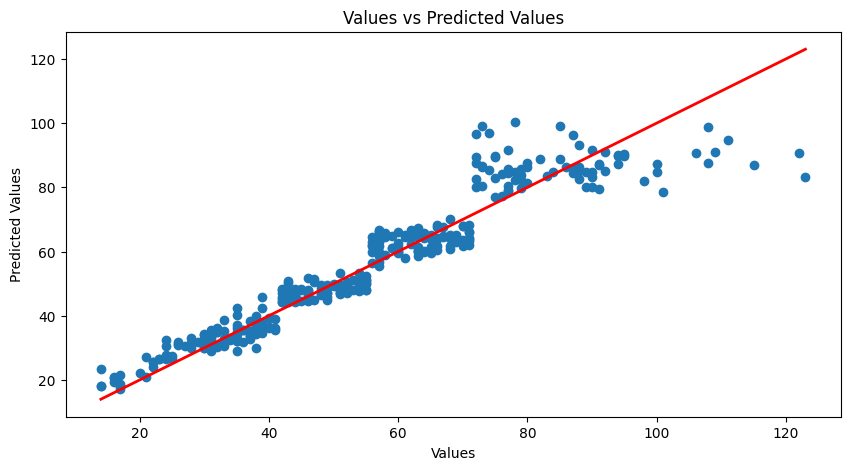

In [111]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('Values')
plt.ylabel('Predicted Values')
plt.title('Values vs Predicted Values')
plt.show()